# Regression with an Abalone Dataset
Run after following notebooks are run:
1. **01_Data_Cleaning**
2. **02_EDA**

## Development Notes/Ideas
- rf
- xgb
- knn
- lasso
- stack
- convert Rings to ordinal categories - this way voting will choose majority vote rather than averaging


## Libraries

In [1]:
## set up libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Load Data

In [2]:
train = pd.read_pickle('train_clean.pkl')
test = pd.read_pickle('test_clean.pkl')

## separate in to features and response variable
x_train = train.drop('Rings', axis=1)
y_train = train['Rings']

x_test = test

## One Hot Encoding / Label Encoding

In [3]:
x_train_onehot = pd.get_dummies(x_train, drop_first=True)
x_test_onehot = pd.get_dummies(x_test, drop_first=True)

## manually add Source_syth to test
x_test_onehot['Source_syth'] = True

print("train dimensions: ", x_train_onehot.shape, "\n","test dimensions: ", x_test_onehot.shape)
x_train_onehot.columns.to_list()

train dimensions:  (94792, 12) 
 test dimensions:  (60411, 12)


['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Volume_cube',
 'Density_meat',
 'Sex_I',
 'Sex_M',
 'Source_syth']

In [4]:
## label encode response variable - used for voting algorithms
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
le.classes_

array([0.69314718, 1.09861229, 1.38629436, 1.60943791, 1.79175947,
       1.94591015, 2.07944154, 2.19722458, 2.30258509, 2.39789527,
       2.48490665, 2.56494936, 2.63905733, 2.7080502 , 2.77258872,
       2.83321334, 2.89037176, 2.94443898, 2.99573227, 3.04452244,
       3.09104245, 3.13549422, 3.17805383, 3.21887582, 3.25809654,
       3.29583687, 3.33220451, 3.40119738])

## Make custom scorer object

In [5]:
## Root Mean Squared Logarithmic Error

## Define function to inverse transform y for scorer calculations
def custom_rmsle_scorer(y_true, y_pred):
    # Apply inverse transformation to y
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    # Calculate RMSLE
    rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
    return rmsle  

## Define custom scorer
rmsle = make_scorer(custom_rmsle_scorer, greater_is_better=False)

## Modelling
### Random Forest Averaging

In [6]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(350,450,50), 'n_jobs' : [-1]}
kf = KFold(n_splits=5, shuffle=True, random_state=888)

rf_tuning = GridSearchCV(RandomForestRegressor(random_state=888), param_grid, scoring=rmsle, cv=kf, n_jobs=-1)
rf_tuning.fit(x_train_onehot.values, y_train)
None

In [7]:
## find best param with highest accuracy
rf_tuning_accr = rf_tuning.cv_results_['mean_test_score']
print('best_params =', rf_tuning.best_params_)
print('best_score =', rf_tuning.best_score_)
print('all_scores =', rf_tuning_accr)

best_params = {'n_estimators': 400, 'n_jobs': -1}
best_score = -0.15328800027107176
all_scores = [-0.15333079 -0.153288  ]


In [8]:
## instantiate rf algorithm, using best tuned param
rf = RandomForestRegressor(n_estimators=400, random_state=888, n_jobs=-1)

## fit model to training data
rf.fit(x_train_onehot.values, y_train); None

#### Feature importance

In [9]:
## List feature importance
rf_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Gini Importance':rf.feature_importances_*100})
rf_ft_imp.sort_values(by='Gini Importance', ascending=False)

,Features,Gini Importance
6,Shell weight,63.957507
8,Density_meat,9.020168
4,Whole weight.1,6.190642
3,Whole weight,4.834508
5,Whole weight.2,4.362609
7,Volume_cube,3.278835
0,Length,2.899807
1,Diameter,2.320181
2,Height,1.512723
9,Sex_I,0.887482


### Random Forest Voting

In [10]:
## instantiate rf algorithm, using best tuned param
rfvot = RandomForestClassifier(n_estimators=400, random_state=888, n_jobs=-1)

## fit model to training data
rfvot.fit(x_train_onehot.values, y_train_le); None

### XGBoost

In [11]:
## Define custom metric function to inverse transform y for metric - xgb.cv requires diff object than GridSearchCV 
    ##  TURNS OUT RMSLE ON UNTRANSFORMED Y, IS THE SAME AS RMSE ON TRANSFORMED LOG(Y+1) - :( at least it was a good learning experience
## Root Mean Squared Logarithmic Error Metric
def rmsle_xgb(y_pred: np.ndarray, dtrain: xgb.DMatrix):
    y_true = np.expm1(dtrain.get_label())
    y_pred = np.expm1(y_pred)
    rmsle_xgb = mean_squared_log_error(y_true, y_pred, squared=False)
    return 'rmsle_xgb', rmsle_xgb

## convert data to DMatrix
x_train_onehot_D = xgb.DMatrix(data=x_train_onehot, label=y_train)

## cross-validation 
## parameters taken from: https://www.kaggle.com/code/thiagomantuani/ps4e4-abalone-regression-baseline/notebook#Models
params = {'objective':'reg:squaredlogerror', 'max_depth':10, 
            'verbosity': 0,
            'booster': 'gbtree',
            'tree_method': 'hist',
            'min_child_weight': 7, 
            'grow_policy': 'lossguide', 
            'gamma': 0.03816426816838989, 
            'subsample': 0.486382907668344, 
            'reg_lambda': 1.7487237399420372, 
            'reg_alpha': 0.013043045359306716,
            'learning_rate': 0.011733966748427322, 
            'colsample_bytree': 0.5748511749872887, }
xgb_tuning_trial = xgb.cv(dtrain=x_train_onehot_D, params=params, num_boost_round=1137, early_stopping_rounds=20, nfold=5, as_pandas=True, seed=888, metrics='rmse', custom_metric=rmsle_xgb)

## mean result
xgb_tuning_trial

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-rmsle_xgb-mean,train-rmsle_xgb-std,test-rmsle_xgb-mean,test-rmsle_xgb-std
0,1.844355,0.000478,1.844354,0.001917,1.844355,0.000478,1.844354,0.001917
1,1.836620,0.000478,1.836620,0.001916,1.836620,0.000478,1.836619,0.001916
2,1.828875,0.000476,1.828874,0.001916,1.828875,0.000477,1.828874,0.001916
3,1.821117,0.000476,1.821117,0.001915,1.821117,0.000476,1.821117,0.001915
4,1.813351,0.000476,1.813351,0.001913,1.813351,0.000476,1.813351,0.001913
...,...,...,...,...,...,...,...,...
1132,0.152896,0.000385,0.153902,0.001681,0.152896,0.000385,0.153902,0.001681
1133,0.152896,0.000385,0.153902,0.001681,0.152896,0.000385,0.153902,0.001681
1134,0.152894,0.000382,0.153900,0.001683,0.152894,0.000383,0.153901,0.001683
1135,0.152894,0.000383,0.153900,0.001683,0.152894,0.000383,0.153901,0.001683


In [12]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(300,600,100), 'max_depth':[8,12], 'eta':[0.1], 'colsample_bytree': [0.5, 0.8], 'reg_alpha':[1],         # parameters to tune
              'objective':['reg:squaredlogerror'], 'n_jobs' : [-1]}                                                                             # fixed parameters
kf = KFold(n_splits=5, shuffle=True, random_state=888)

xgb_tuning = GridSearchCV(xgb.XGBRegressor(random_state=888), param_grid, scoring=rmsle, cv=kf)
xgb_tuning.fit(x_train_onehot.values, y_train)
None

In [13]:
## find best param with highest accuracy
xgb_tuning_accr = xgb_tuning.cv_results_['mean_test_score']
print('best_params =', xgb_tuning.best_params_)
print('best_score =', xgb_tuning.best_score_)
print('all_scores =', xgb_tuning_accr)

best_params = {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 12, 'n_estimators': 500, 'n_jobs': -1, 'objective': 'reg:squaredlogerror', 'reg_alpha': 1}
best_score = -0.14983887273860094
all_scores = [-0.15010514 -0.14994807 -0.14986434 -0.15004648 -0.14991067 -0.14983887
 -0.1500754  -0.14996162 -0.14989114 -0.15001349 -0.14991612 -0.14986721]


In [14]:
## instantiate xgb algorithm, using best tuned param
xgbreg = xgb.XGBRegressor(n_estimators= 500, max_depth=12, eta=0.1, colsample_bytree=0.5, reg_alpha=1, objective='reg:squaredlogerror', random_state=888, n_jobs=-1)

## fit model to training data
xgbreg.fit(x_train_onehot.values, y_train); None

In [23]:
## List feature importance
xgb_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Feature Importance':xgbreg.feature_importances_*100})
xgb_ft_imp.sort_values(by='Feature Importance', ascending=False)

,Features,Feature Importance
6,Shell weight,27.073637
2,Height,19.367958
9,Sex_I,18.667500
7,Volume_cube,18.334476
3,Whole weight,5.654060
1,Diameter,3.638107
8,Density_meat,2.569929
0,Length,2.509975
4,Whole weight.1,1.160800
5,Whole weight.2,0.676027


## Test Predictions

In [19]:
## set up submission format - i.e. id & Rings
submission = pd.read_csv('Data_Download/sample_submission.csv')
submission['Rings'] = ''

CHECK count of Rings==28 : 0


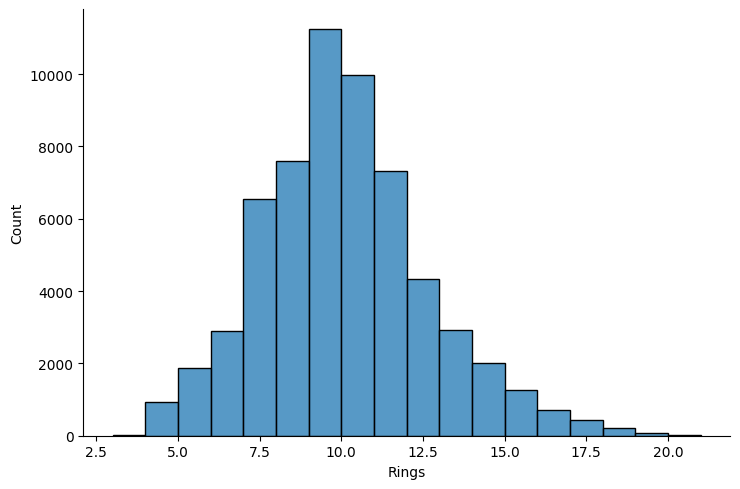

In [16]:
## rf prediction
y_testpred_rf = rf.predict(x_test_onehot.values)
y_testpred_rf = np.exp(y_testpred_rf)-1
y_testpred_rf = np.round(y_testpred_rf)
submission['Rings'] = y_testpred_rf
submission.to_csv('Submissions/test_pred_rf_v2.csv', index=False)

## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)

CHECK count of Rings==28 : 0


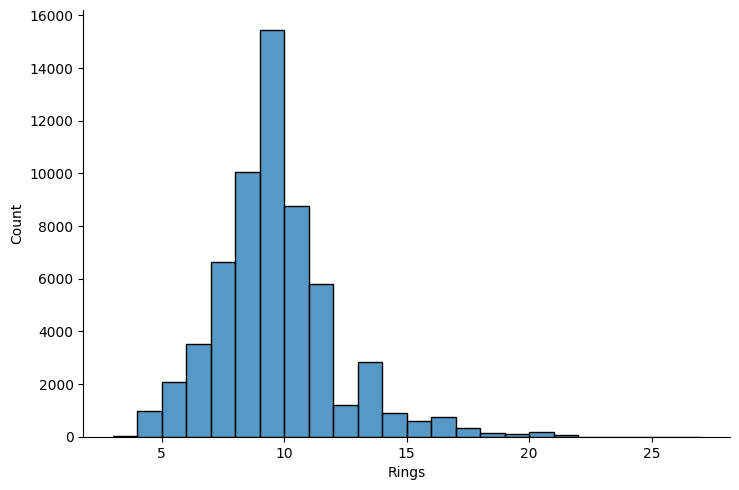

In [17]:
## rfvot prediction
y_testpred_rfvot = rfvot.predict(x_test_onehot.values)
y_testpred_rfvot = le.inverse_transform(y_testpred_rfvot)
y_testpred_rfvot = np.exp(y_testpred_rfvot)-1
y_testpred_rfvot = np.round(y_testpred_rfvot)
submission['Rings'] = y_testpred_rfvot
submission.to_csv('Submissions/test_pred_rfvot_v1.csv', index=False)

## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)

CHECK count of Rings==28 : 0


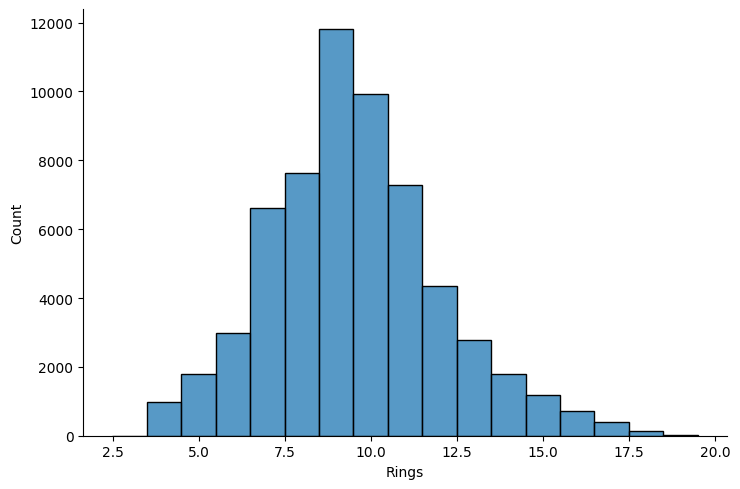

In [34]:
## xgbreg prediction
y_testpred_xgbreg = xgbreg.predict(x_test_onehot.values)
y_testpred_xgbreg = np.expm1(y_testpred_xgbreg)
# y_testpred_xgbreg = np.round(y_testpred_xgbreg)
submission['Rings'] = y_testpred_xgbreg
submission.to_csv('Submissions/test_pred_xgbreg_v4.csv', index=False)

## CHECKS
## check Rings!=28
print('CHECK count of Rings==28 :',sum(submission.Rings==28))

## test prediction histogram of Rings
g=sns.displot(data=submission, x='Rings', binwidth=1, aspect=1.5)